# 0.0. Imports

## 0.1. Libraries

In [22]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble      import RandomForestClassifier
import xgboost as xgb
from sklearn import metrics as mt
import optuna
from sklearn.ensemble      import RandomForestRegressor, GradientBoostingClassifier
import optuna
from boruta                import BorutaPy


## 0.2. Data

In [2]:
df = pd.read_csv('train.csv')

## 0.3. Helper Functions

In [3]:
def plot_barras_empilhadas(data_barras_emp, variavel_barras_emp, target_barras_emp, figsize = (6,4)):

    aux_barras_emp  = data_barras_emp[[variavel_barras_emp, target_barras_emp]]
    aux1_barras_emp = aux_barras_emp.groupby(variavel_barras_emp).count().reset_index()
    aux1_barras_emp[target_barras_emp] = 1
    aux2_barras_emp = pd.DataFrame(aux_barras_emp.value_counts([variavel_barras_emp, target_barras_emp])).reset_index().sort_values(target_barras_emp)
    aux3_barras_emp = pd.DataFrame(aux2_barras_emp.groupby(variavel_barras_emp).sum()[0]).reset_index()
    aux3_barras_emp = pd.merge(aux2_barras_emp, aux3_barras_emp, how = 'left', on = variavel_barras_emp)
    aux3_barras_emp['percentage'] = aux3_barras_emp['0_x'] / aux3_barras_emp['0_y']
    aux3_barras_emp = aux3_barras_emp.sort_values('percentage')
    

    plt.figure(figsize = figsize)
    
    bar1 = sns.barplot(x = variavel_barras_emp, y = target_barras_emp, data =  aux1_barras_emp, color = 'darkblue')
    bar2 = sns.barplot(x = variavel_barras_emp, y = 'percentage', data = aux3_barras_emp[aux3_barras_emp[target_barras_emp] == 1], color = 'lightblue')

In [4]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [96]:
def remove_outliers_iqr(data):
    for c in num_var.columns:
        if (c in data.columns):
            Q1 = data[c].quantile(0.25)
            Q3 = data[c].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
    return data[(data[c] >= lower_bound) & (data[c] <= upper_bound)]

In [5]:
def scaler_mms(data):
    mms = MinMaxScaler()
    for c in num_var.columns:
        if c in data and c!='Attrition':
            data[c] = mms.fit_transform(data[[c]].values)
    return data

def scaler_ss(data):
    ss = StandardScaler()
    for c in num_var.columns:
        if c in data and c!='Attrition':
            data[c] = ss.fit_transform(data[[c]].values)
    return data

def scaler_rs(data):
    rs = RobustScaler()
    for c in num_var.columns:
        if c in data and c!='Attrition':
            data[c] = rs.fit_transform(data[[c]].values)
    return data

In [6]:
def label_enc(data):
    le = LabelEncoder()
    for c in cat_var.columns:
        if c in data:
            data[c] = le.fit_transform(data[c])
    return data

def onehot_enc(data):
    for c in cat_var.columns:
        if c in data:
            data = pd.get_dummies(data, prefix=c, columns=[c])
    return data

def freq_enc(data):
    for c in cat_var.columns:
        if c in data:
            freq_dict = data[c].value_counts(normalize=True).to_dict()
            data[c] = data[c].map(freq_dict)
    return data

In [7]:
def cross_val( X, y, model, cv, limiar = 0.5, verbose = True):
    
    scores = []
    
    for cv in np.arange(1,cv+1):
    
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2 )

        model.fit(X_train, y_train)

        # Predictions
        probas = model.predict_proba(X_test)
        probas = probas.T[1]

        predictions = []

        for proba in probas:
            if proba > limiar:
                predictions.append(1)
            else:
                predictions.append(0)

        # Model evaluation
        score = mt.roc_auc_score(y_test, predictions)
        scores.append(score)
        
    if verbose == True:
        print('Score:',round(100*np.mean(scores),2))

    return np.mean(scores)

# 1.0. Data Description

In [8]:
df1 = df.copy()

In [35]:
df1.head()

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,...,80,1,10,2,3,10,0,7,8,0
1,1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,...,80,1,4,3,3,4,2,0,3,0
2,2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,...,80,2,4,3,3,3,2,1,2,0
3,3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,...,80,0,15,1,1,6,0,0,2,0
4,4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,...,80,0,31,0,3,31,14,4,10,1


## 1.1. Dimensions

In [4]:
print("The dataset has {} rows and {} columns".format(df1.shape[0], df1.shape[1]))

The dataset has 1677 rows and 35 columns


## 1.2. Types

In [5]:
df1.dtypes

id                           int64
Age                          int64
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                      object
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears            int64
TrainingTimesLastYea

## 1.3. NaN's

In [8]:
df1.isna().sum()

id                          0
Age                         0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithC

## 1.4. Duplicates

In [9]:
df1.drop_duplicates(inplace=True)

## 1.5. Unique Values

In [34]:
df1.nunique()

id                          1677
Age                           43
BusinessTravel                 3
DailyRate                    625
Department                     3
DistanceFromHome              29
Education                      6
EducationField                 6
EmployeeCount                  1
EnvironmentSatisfaction        4
Gender                         2
HourlyRate                    71
JobInvolvement                 4
JobLevel                       6
JobRole                        9
JobSatisfaction                4
MaritalStatus                  3
MonthlyIncome                895
MonthlyRate                  903
NumCompaniesWorked            10
Over18                         1
OverTime                       2
PercentSalaryHike             15
PerformanceRating              2
RelationshipSatisfaction       4
StandardHours                  1
StockOptionLevel               4
TotalWorkingYears             41
TrainingTimesLastYear          7
WorkLifeBalance                4
YearsAtCom

The features "EmployeeCount", "Over18" and "StandardHours" only have one value each, so they will be removed from the dataset

# 2.0. Feature Engineering

In [10]:
df2 = df1.copy()

## 2.1. Removing Features

In [11]:
df2.drop(columns=["EmployeeCount", "Over18","StandardHours"], inplace=True)

# 3.0. Exploratory Data Analysis

In [12]:
df3 = df2.copy()

In [13]:
num_var = df3.select_dtypes(include=['int64','int64'])
cat_var = df3.select_dtypes(exclude=['int64','int64'])

## 3.1. Descriptive Statistics

### 3.1.1. Numerical Variables

In [48]:
num_var.describe()

,id,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
count,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,...,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000
mean,838.000000,36.036971,892.749553,8.683959,2.937984,2.757901,67.798450,2.782349,1.998807,2.791890,...,2.751342,0.721527,10.709600,2.732856,2.769827,6.806798,4.144305,1.978533,4.186643,0.119261
std,484.252517,8.507112,374.496259,7.826143,1.039078,1.086835,19.435928,0.650664,1.083065,1.097396,...,1.077905,0.771259,7.255135,1.145271,0.647721,5.883282,3.583398,3.045716,3.576189,0.324192
min,0.000000,18.000000,107.000000,1.000000,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,419.000000,30.000000,589.000000,2.000000,2.000000,2.000000,51.000000,2.000000,1.000000,2.000000,...,2.000000,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000,0.000000
50%,838.000000,35.000000,890.000000,7.000000,3.000000,3.000000,69.000000,3.000000,2.000000,3.000000,...,3.000000,1.000000,9.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000,0.000000
75%,1257.000000,41.000000,1223.000000,12.000000,4.000000,4.000000,84.000000,3.000000,2.000000,4.000000,...,4.000000,1.000000,14.000000,3.000000,3.000000,9.000000,7.000000,2.000000,7.000000,0.000000
max,1676.000000,60.000000,3921.000000,29.000000,15.000000,4.000000,100.000000,4.000000,7.000000,4.000000,...,4.000000,3.000000,41.000000,6.000000,4.000000,41.000000,18.000000,15.000000,17.000000,1.000000


### 3.1.2. Categorical Variables

In [49]:
cat_var.describe(include='object')

,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,OverTime
count,1677,1677,1677,1677,1677,1677,1677
unique,3,3,6,2,9,3,2
top,Travel_Rarely,Research & Development,Life Sciences,Male,Sales Executive,Married,No
freq,1290,1167,775,1064,355,773,1277


## 3.2. Univariate Analysis

### 3.2.1. Target Variable

In [21]:
px.pie(df3, names='Attrition')

### 3.2.2. Numerical Variables

In [50]:
for c in num_var.columns:
    px.box(df3, y=c).show()

### 3.2.3. Categorical Variables

In [37]:
for c in cat_var.columns:
    if cat_var[c].nunique()<=3:
        px.pie(df3, names=c).show()
    else:
        df_aux = df3.loc[:,[c,'id']].groupby(c).count().sort_values('id', ascending=True).reset_index()
        px.bar(df_aux, x=c, y='id', color=c).show()

## 3.3. Bivariate Analysis

### 3.3.1. Numerical Variables

In [16]:
df_aux = df3.loc[:,['Age','Attrition']].groupby("Age").mean().sort_values("Age", ascending=True).reset_index()
px.line(df_aux, x='Age', y='Attrition').show()

The graph shows that younger employees tend to have more attrition on average.

In [27]:
px.scatter(df3, x='DailyRate', y='Attrition').show()

In [11]:
df_aux = df3.loc[:,['DistanceFromHome','Attrition']].groupby("DistanceFromHome").mean().sort_values("DistanceFromHome", ascending=True).reset_index()
px.line(df_aux, x='DistanceFromHome', y='Attrition').show()

In [12]:
df_aux = df3.loc[:,['Education','Attrition']].groupby("Education").mean().sort_values("Education", ascending=True).reset_index()
px.line(df_aux, x='Education', y='Attrition').show()

We can see from the graph tha the higher the education the less likely the employee is to get into attrition

In [14]:
df_aux = df3.loc[:,['EnvironmentSatisfaction','Attrition']].groupby("EnvironmentSatisfaction").mean().sort_values("EnvironmentSatisfaction", ascending=True).reset_index()
px.line(df_aux, x='EnvironmentSatisfaction', y='Attrition').show()

The employees get into more attrition when they're less satisfied with the enviroment

In [19]:
df_aux = df3.loc[:,['HourlyRate','Attrition']].groupby("HourlyRate").mean().sort_values("HourlyRate", ascending=True).reset_index()
px.line(df_aux, x='HourlyRate', y='Attrition').show()

In [22]:
df_aux = df3.loc[:,['JobInvolvement','Attrition']].groupby("JobInvolvement").mean().sort_values("JobInvolvement", ascending=True).reset_index()
px.line(df_aux, x='JobInvolvement', y='Attrition').show()

We can see that employees more involved with their jobs are less likely to get into attrition

In [23]:
df_aux = df3.loc[:,['JobLevel','Attrition']].groupby("JobLevel").mean().sort_values("JobLevel", ascending=True).reset_index()
px.line(df_aux, x='JobLevel', y='Attrition').show()

The graph shows that employees in higher levels of their carreers get into less attrition

In [24]:
df_aux = df3.loc[:,['JobSatisfaction','Attrition']].groupby("JobSatisfaction").mean().sort_values("JobSatisfaction", ascending=True).reset_index()
px.line(df_aux, x='JobSatisfaction', y='Attrition').show()

The graph shows that employees more satisfied with their jobs are in general less likely to get into attrition

In [27]:
df_aux = df3.loc[:,['MonthlyIncome','Attrition']].groupby("MonthlyIncome").mean().sort_values("MonthlyIncome", ascending=True).reset_index()
px.line(df_aux, x='MonthlyIncome', y='Attrition').show()

We can see that higher paid employees are less likely to get into attrition

In [29]:
df_aux = df3.loc[:,['MonthlyRate','Attrition']].groupby("MonthlyRate").mean().sort_values("MonthlyRate", ascending=True).reset_index()
px.scatter(df_aux, x='MonthlyRate', y='Attrition').show()

In [31]:
df_aux = df3.loc[:,['NumCompaniesWorked','Attrition']].groupby("NumCompaniesWorked").mean().sort_values("NumCompaniesWorked", ascending=True).reset_index()
px.line(df_aux, x='NumCompaniesWorked', y='Attrition').show()

In [38]:
df_aux = df3.loc[:,['PercentSalaryHike','Attrition']].groupby("PercentSalaryHike").mean().sort_values("PercentSalaryHike", ascending=True).reset_index()
px.line(df_aux, x='PercentSalaryHike', y='Attrition').show()

In [39]:
df_aux = df3.loc[:,['PerformanceRating','Attrition']].groupby("PerformanceRating").mean().sort_values("PerformanceRating", ascending=True).reset_index()
px.line(df_aux, x='PerformanceRating', y='Attrition').show()

The graph shows that the better an employee performs, the more attrition he tends to get into.

In [40]:
df_aux = df3.loc[:,['RelationshipSatisfaction','Attrition']].groupby("RelationshipSatisfaction").mean().sort_values("RelationshipSatisfaction", ascending=True).reset_index()
px.line(df_aux, x='RelationshipSatisfaction', y='Attrition').show()

The graph shows that the more satisfied the employees are in their relationships, the less likely they are to get into attrition

In [41]:
df_aux = df3.loc[:,['StockOptionLevel','Attrition']].groupby("StockOptionLevel").mean().sort_values("StockOptionLevel", ascending=True).reset_index()
px.line(df_aux, x='StockOptionLevel', y='Attrition').show()

In [42]:
df_aux = df3.loc[:,['TotalWorkingYears','Attrition']].groupby("TotalWorkingYears").mean().sort_values("TotalWorkingYears", ascending=True).reset_index()
px.line(df_aux, x='TotalWorkingYears', y='Attrition').show()

In [43]:
df_aux = df3.loc[:,['TrainingTimesLastYear','Attrition']].groupby("TrainingTimesLastYear").mean().sort_values("TrainingTimesLastYear", ascending=True).reset_index()
px.line(df_aux, x='TrainingTimesLastYear', y='Attrition').show()

In [44]:
df_aux = df3.loc[:,['WorkLifeBalance','Attrition']].groupby("WorkLifeBalance").mean().sort_values("WorkLifeBalance", ascending=True).reset_index()
px.line(df_aux, x='WorkLifeBalance', y='Attrition').show()

Employees that have a better balance between work and life are less likely to get into attrition

In [45]:
df_aux = df3.loc[:,['YearsAtCompany','Attrition']].groupby("YearsAtCompany").mean().sort_values("YearsAtCompany", ascending=True).reset_index()
px.line(df_aux, x='YearsAtCompany', y='Attrition').show()

In [46]:
df_aux = df3.loc[:,['YearsInCurrentRole','Attrition']].groupby("YearsInCurrentRole").mean().sort_values("YearsInCurrentRole", ascending=True).reset_index()
px.line(df_aux, x='YearsInCurrentRole', y='Attrition').show()

In [47]:
df_aux = df3.loc[:,['YearsSinceLastPromotion','Attrition']].groupby("YearsSinceLastPromotion").mean().sort_values("YearsSinceLastPromotion", ascending=True).reset_index()
px.line(df_aux, x='YearsSinceLastPromotion', y='Attrition').show()

In [48]:
df_aux = df3.loc[:,['YearsWithCurrManager','Attrition']].groupby("YearsWithCurrManager").mean().sort_values("YearsWithCurrManager", ascending=True).reset_index()
px.line(df_aux, x='YearsWithCurrManager', y='Attrition').show()

### 3.3.2. Categorical Variables

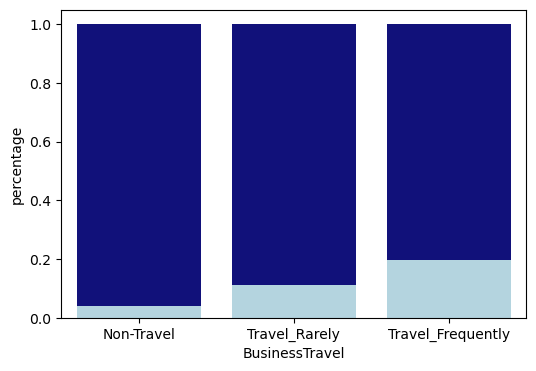

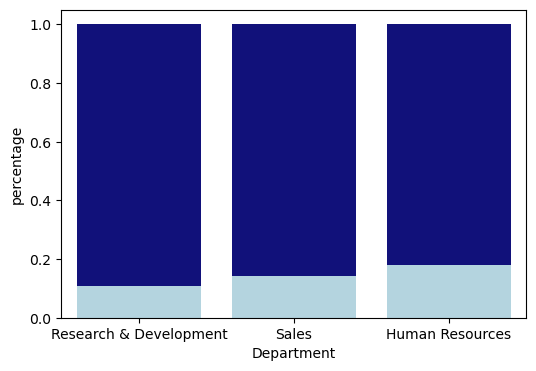

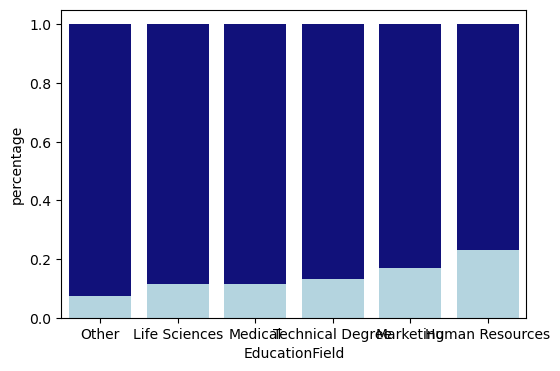

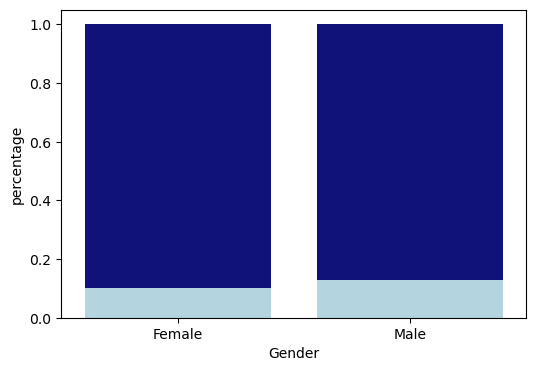

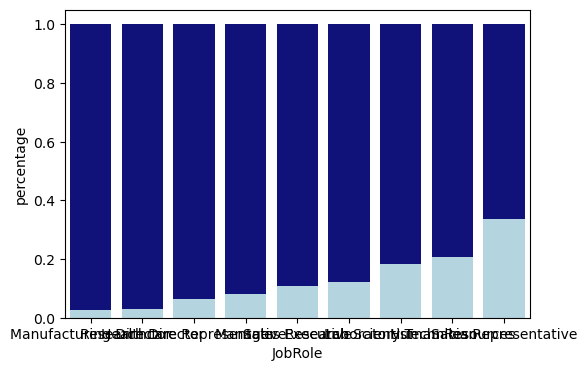

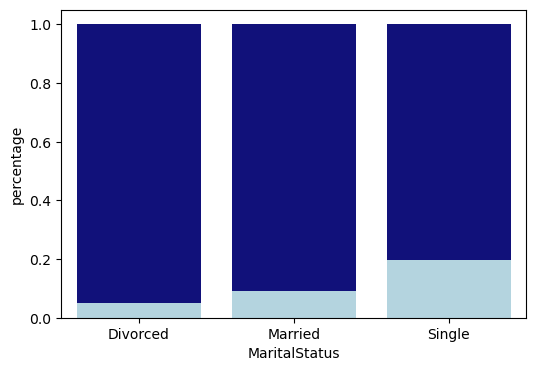

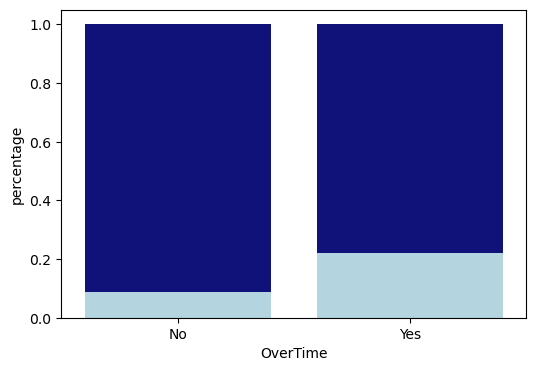

In [62]:
for c in cat_var.columns:
    plot_barras_empilhadas(df3, c, 'Attrition', figsize = (6,4))

## 3.4. Multivariate Analysis

### 3.4.1. Numerical Variables

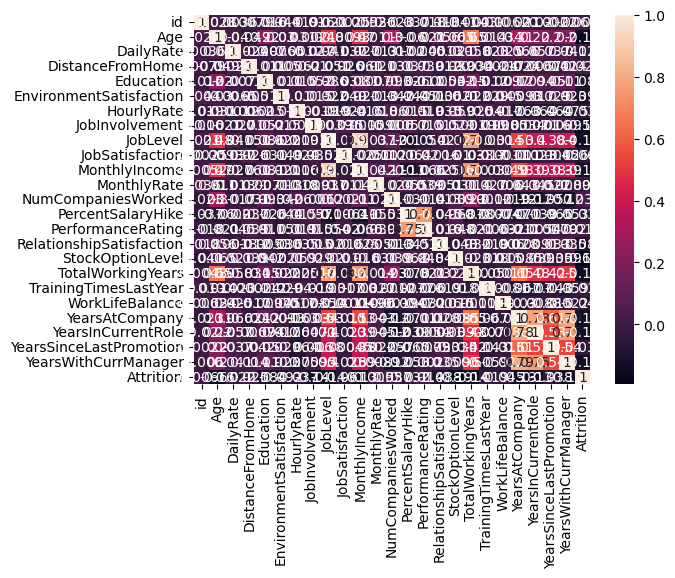

In [73]:
correlation = num_var.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 3.4.2. Categorical Variables

<AxesSubplot:>

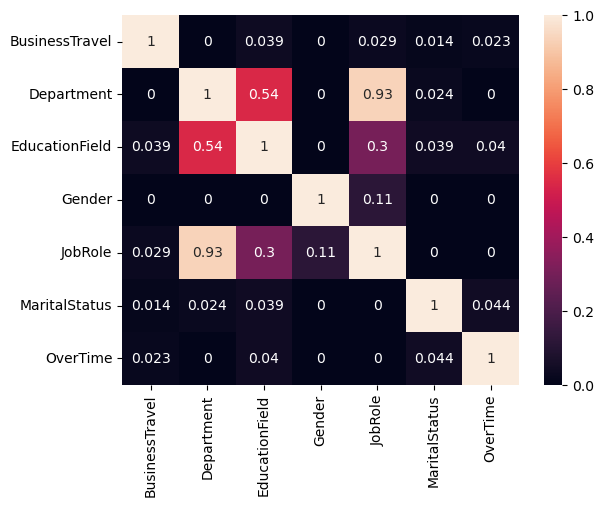

In [76]:
corr_matrix = pd.DataFrame(index=cat_var.columns, columns=cat_var.columns)

for i in range(len(cat_var.columns)):
    for j in range(len(cat_var.columns)):
        corr_matrix.iloc[i,j] = cramers_v(cat_var.iloc[:,i], cat_var.iloc[:,j])

corr_matrix = corr_matrix.astype(float)

sns.heatmap(corr_matrix, annot=True)

# 4.0. Data Preprocessing

In [14]:
df4 = df3.copy()

## 4.1. Removing Numerical Outliers

## 4.2. Numerical Rescaling

In [15]:
df4 = scaler_mms(df4)
#df4 = scaler_ss(df4)
#df4 = scaler_rs(df4)

## 4.3. Categorical Encoding

In [16]:
#df4 = onehot_enc(df4)
#df4 = label_enc(df4)
df4 = freq_enc(df4)

# 5.0. Feature Selection

In [17]:
df5 = df4.copy()

## 5.2. Splitting Dataset

In [28]:
x = df5.drop(columns=['id','Attrition'])
y = df5['Attrition']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# 6.0. Machine Learning Modeling

In [29]:
df6 = df5.copy()

## 6.1. Random Forest

In [30]:
rf_model = RandomForestClassifier(n_estimators = 500)
cross_val(x, y, rf_model, 10, limiar = 0.5, verbose = True)

Score: 53.21


0.5321005009979054

## 6.2. XGBoost

In [31]:
xgb_model = xgb.XGBClassifier(n_estimators = 500)
cross_val(x, y, xgb_model, 10, limiar = 0.5, verbose = True)

Score: 60.07


0.6007443456857897